# Classifying BBC Full Text with BERT



This Notebook will show you how to fine-tune BERT for *document* classification tasks using the [BBC Full Text](https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification) dataset as an example.

# Contents

See "Table of contents" in the sidebar to the left.

# Part I - Setup & Dataset Prep
-------------------------------

## 1. Setup


### 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
!nvidia-smi

Thu Jan 14 14:15:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    77W / 149W |    133MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. 

In [4]:
!pip install -qq transformers

## 2. Retrieve & Inspect Dataset




This notebook will download and tokenize a text dataset.

We'll use torch.Dataset to build our dataset.

### 2.1. Download
--------------------------------------
Download the text.

First of all, you have to upload your kaggle credential. Just check [this link](https://www.kaggle.com/docs/api) if you don't know what is it.

In [5]:
!pip install -qq kaggle
!pip install -qq --upgrade --force-reinstall --no-deps kaggle

In [19]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [20]:
!mv kaggle.json /root/.kaggle/

In [21]:
!chmod 600 /root/.kaggle/kaggle.json

In [22]:
!kaggle datasets download -d shivamkushwaha/bbc-full-text-document-classification

 72% 4.00M/5.59M [00:00<00:00, 5.03MB/s]
100% 5.59M/5.59M [00:00<00:00, 6.98MB/s]


In [23]:
!unzip -qq bbc-full-text-document-classification.zip

### 2.2. Parse & Inspect
-------------------


In [6]:
from typing import List, Mapping, Tuple

In [7]:
import logging
import os
from pathlib import Path

In [8]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
from tqdm import tqdm

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [13]:
text_dir = Path('bbc')
set_of_labels = [label for label in os.listdir(text_dir) if os.path.isdir(text_dir / label)]

In [14]:
texts = []
labels = []

for label in tqdm(set_of_labels):
    files_path = text_dir / label
    for file_name in os.listdir(files_path):
        if not file_name.endswith('.txt'):
            continue
        with open(files_path / file_name, 'r', encoding="utf8", errors='ignore') as f:
            text = f.read()
            texts.append(text)
            labels.append(label)

100%|██████████| 5/5 [00:00<00:00, 52.13it/s]


In [15]:
TEXT_COLUMN = 'text'
LABEL_COLUMN = 'label'

data_df = pd.DataFrame({
    TEXT_COLUMN: texts,
    LABEL_COLUMN: labels
})
data_df.shape

(2225, 2)

Let's take a look at the first few rows of the table just to see what's in there.

In [16]:
data_df.head()

,text,label
0,Hollywood hunts hits at Sundance\n\nThe Sundan...,entertainment
1,Day-Lewis set for Berlin honour\n\nActor Danie...,entertainment
2,Musical treatment for Capra film\n\nThe classi...,entertainment
3,Top gig award for Scissor Sisters\n\nNew York ...,entertainment
4,Prodigy join V Festival line-up\n\nEssex act P...,entertainment


Let's take a look at the distribution of our labels

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


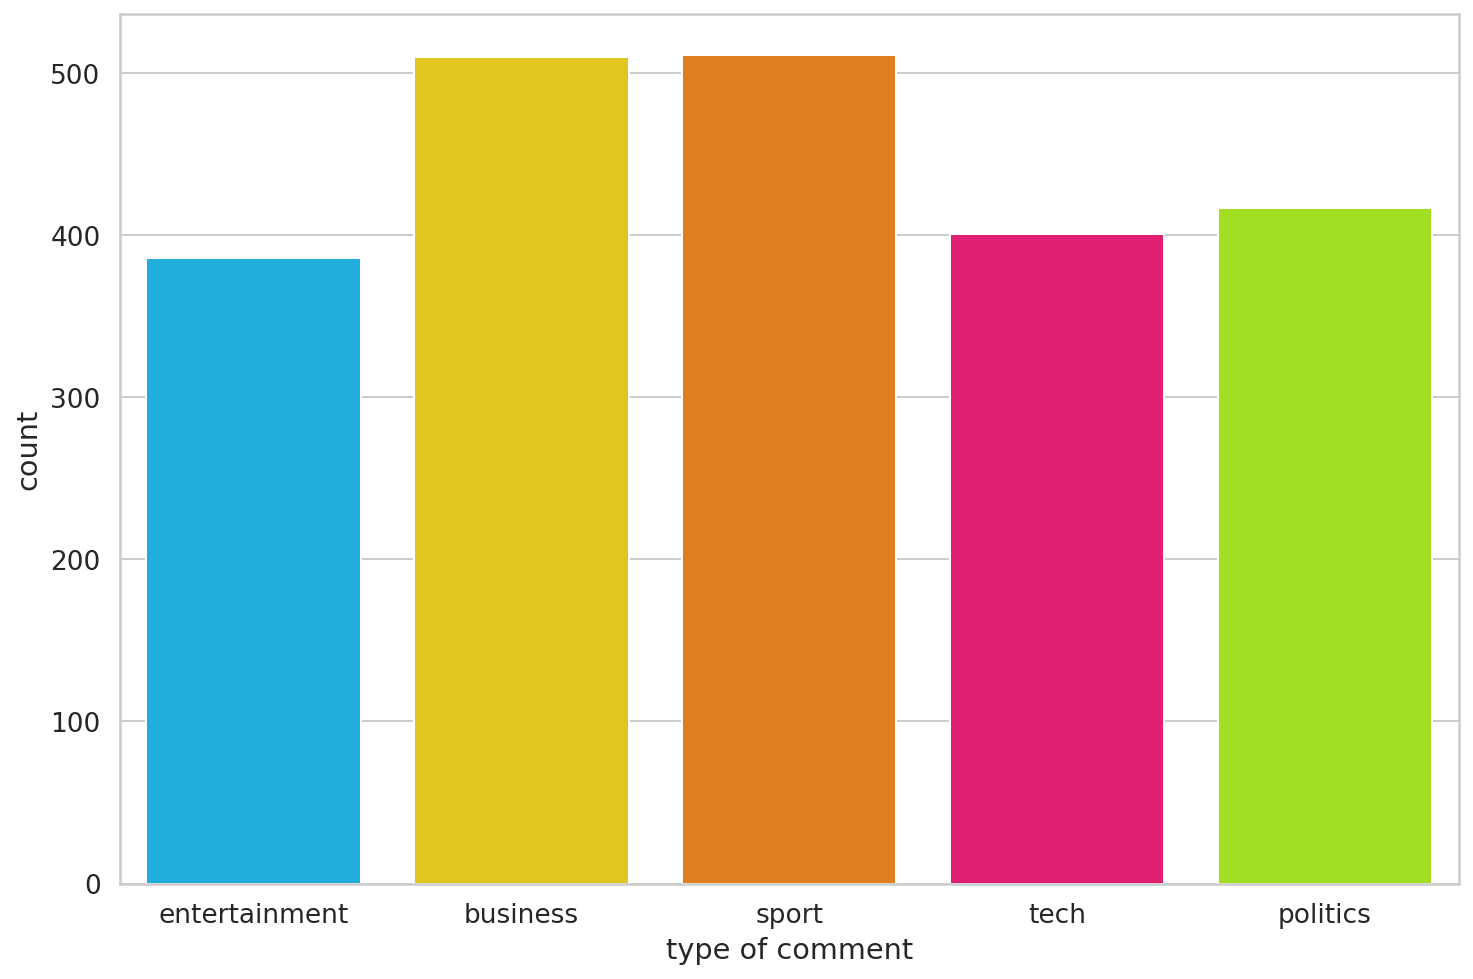

In [17]:
ax = sns.countplot(data_df.label)
plt.xlabel('type of comment');

In [18]:
# some constants for text cleaning
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

def text_cleaning(text: str) -> str:
    """
    Args:
        text (str): a string
    Returns:
        modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [19]:
data_df.text = data_df.text.apply(text_cleaning)

Let's take a look at the first few rows of the table after text cleaning

In [20]:
data_df.head()

,text,label
0,hollywood hunts hits sundancethe sundance film...,entertainment
1,daylewis set berlin honouractor daniel daylewi...,entertainment
2,musical treatment capra filmthe classic film w...,entertainment
3,top gig award scissor sistersnew york band sci...,entertainment
4,prodigy join v festival lineupessex act prodig...,entertainment


Next, we should divide our dataset on train, validation and test

In [21]:
df_train, df_test = train_test_split(data_df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [22]:
df_train.shape, df_val.shape, df_test.shape

((2002, 2), (111, 2), (112, 2))

Let's define class of our Dataset

In [23]:
class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(
        self,
        texts: List[str],
        labels: List[str] = None,
        label_dict: Mapping[str, int] = None,
        max_seq_length: int = 512,
        model_name: str = "distilbert-base-uncased",
    ):
        """
        Args:
            text_dir (str): a list with texts to classify or to train the
                classifier on
            labels (List[str]): a list with classification labels (optional)
            label_dict (dict): a dictionary mapping class names to class ids,
                to be passed to the validation data (optional)
            max_seq_length (int): maximal sequence length in tokens,
                texts will be stripped to this length
            model_name (str): transformer model name, needed to perform
                appropriate tokenization
        """

        self.texts = texts
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            # {'class1': 0, 'class2': 1, 'class3': 2, ...}
            # using this instead of `sklearn.preprocessing.LabelEncoder`
            # no easily handle unknown target values
            self.label_dict = dict(
                zip(sorted(set(labels)), range(len(set(labels))))
            )

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # suppresses tokenizer warnings
        logging.getLogger("transformers.tokenization_utils").setLevel(
            logging.FATAL
        )

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.texts)

    def __getitem__(self, index: int) -> Mapping[str, torch.Tensor]:
        """Gets element of the dataset
        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """

        # encoding the text
        x = self.texts[index]

        # a dictionary with `input_ids` and `attention_mask` as keys
        output_dict = self.tokenizer.encode_plus(
            x,
            add_special_tokens=True,
            padding="max_length",
            max_length=self.max_seq_length,
            return_tensors="pt",
            truncation=True,
            return_attention_mask=True,
        )

        output_dict["input_ids"] = output_dict["input_ids"].flatten()
        output_dict["attention_mask"] = output_dict["attention_mask"].flatten()

        # encoding target
        if self.labels is not None:
            y = self.labels[index]
            y_encoded = (
                torch.Tensor([self.label_dict.get(y, -1)]).long().squeeze(0)
            )
            output_dict["targets"] = y_encoded

        return output_dict


We have to define some constants

In [24]:
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
MODEL_NAME = 'distilbert-base-uncased'

In [25]:
train_dataset = TextClassificationDataset(
    texts=df_train[TEXT_COLUMN].values.tolist(),
    labels=df_train[LABEL_COLUMN].values,
    max_seq_length=MAX_SEQ_LEN,
    model_name=MODEL_NAME,
)

valid_dataset = TextClassificationDataset(
    texts=df_val[TEXT_COLUMN].values.tolist(),
    labels=df_val[LABEL_COLUMN].values,
    max_seq_length=MAX_SEQ_LEN,
    model_name=MODEL_NAME,
)

test_dataset = TextClassificationDataset(
    texts=df_test[TEXT_COLUMN].values.tolist(),
    labels=df_test[LABEL_COLUMN].values,
    max_seq_length=MAX_SEQ_LEN,
    model_name=MODEL_NAME,
)

In [26]:
train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## 3. BERT Input Length Limitation

BERT has a maximum input length of 512 tokens. In this section, we'll look at how this limitation affects us in practice, and some possible approaches for addressing it.

### 3.1. Examples of 512 Tokens

Let's look at an example comment which gets split into more than 512 tokens, so that we can get a sense for how much text fits within this limit.

First we'll need to load the DistilBERT tokenizer.

In [27]:
# Load the DistilBERT tokenizer.

print('Loading DistilBERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Loading DistilBERT tokenizer...


Let's have a look at an example batch from our training data loader:

In [28]:
mini_batch_data = next(iter(train_data_loader))
mini_batch_data.keys()

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [29]:
print(mini_batch_data['input_ids'].shape)
print(mini_batch_data['attention_mask'].shape)
print(mini_batch_data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


### 3.2. Strategies for Longer Text

Key points:
* There's no *obvious* solution, but we'll cover a number of ideas to try.
* Looking at the statistics of your dataset should help when choosing your strategy. We'll do this in section 3.3.

There was a [paper published](https://arxiv.org/pdf/1905.05583.pdf) recently that investigated this problem and experimented with a few approaches.  Check out section 5.3. specifically. 

![BERT Text Classification Paper](http://www.mccormickml.com/assets/BERT/text_classification_paper.png)




**Truncation**

The simplest approach is just to drop some of the tokens, and hope that the remaining text is enough to perform the task well.

You could drop tokens:
* From the beginning of the text.
* At the end of the text.
* In the middle of the text.

In the above paper, their experiments on the IMDb movie review dataset showed that keeping the first 128 tokens and the last 382 tokens performed best. (Note: This adds up to 510 tokens, leaving room for the special `[CLS]` and `[SEP]` tokens that we have to append to the beginning and the end of the text, respectively). 

Perhaps this is because, when writing something like a movie review, we tend to put our high-level points in the introduction and conclusion?



**Chunking**

Another approach attempted by the authors (and also proposed in [this thread](https://github.com/google-research/bert/issues/650) in the BERT GitHub repo) would be to divide the text into 512-token chunks and generate embeddings for these chunks separately. 

The authors of the paper combined the embeddings for the different chunks before performing the final classification. They tried several "pooling" strategies, such as averaging the embeddings together. None of these approaches outperformed the simple truncation approach, however.

In the GitHub discussion above, the user suggested instead classifying the chunks separately and then averaging together the predictions. 

Mariano Kamp, in a comment on my YouTube video, also made the insightful observation that these "chunking" approaches could be computationly expensive when dealing with lengthy documents. 


### 3.3. Comment Length Distribution

To decide on a truncation strategy for this dataset, let's first look at the distribution of comment lenghts.

To do this, our first step is to tokenize all of the comments in the training set.

**Tokenize All Comments**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In order to explore the distribution of comment lengths, we will not perform any truncation here. Unfortunately, this results in the tokenizer spitting out a warning for every comment that's longer than 512 tokens. We'll just have to ignore those for now!

In [30]:
import numpy as np

# Record the length of each sequence (after truncating to 512).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for sen in df_train.text:
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Record the truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')

Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
DONE.


Let's grab some quick statistics--what are the min, max and median comment lenghts?

In [31]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 59 tokens
   Max length: 2,594 tokens
Median length: 237.5 tokens


To further analyze it, let's plot the distribution. To keep the scale of the x-axis reasonable, *we'll clip the lengths to 512.*


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Text')

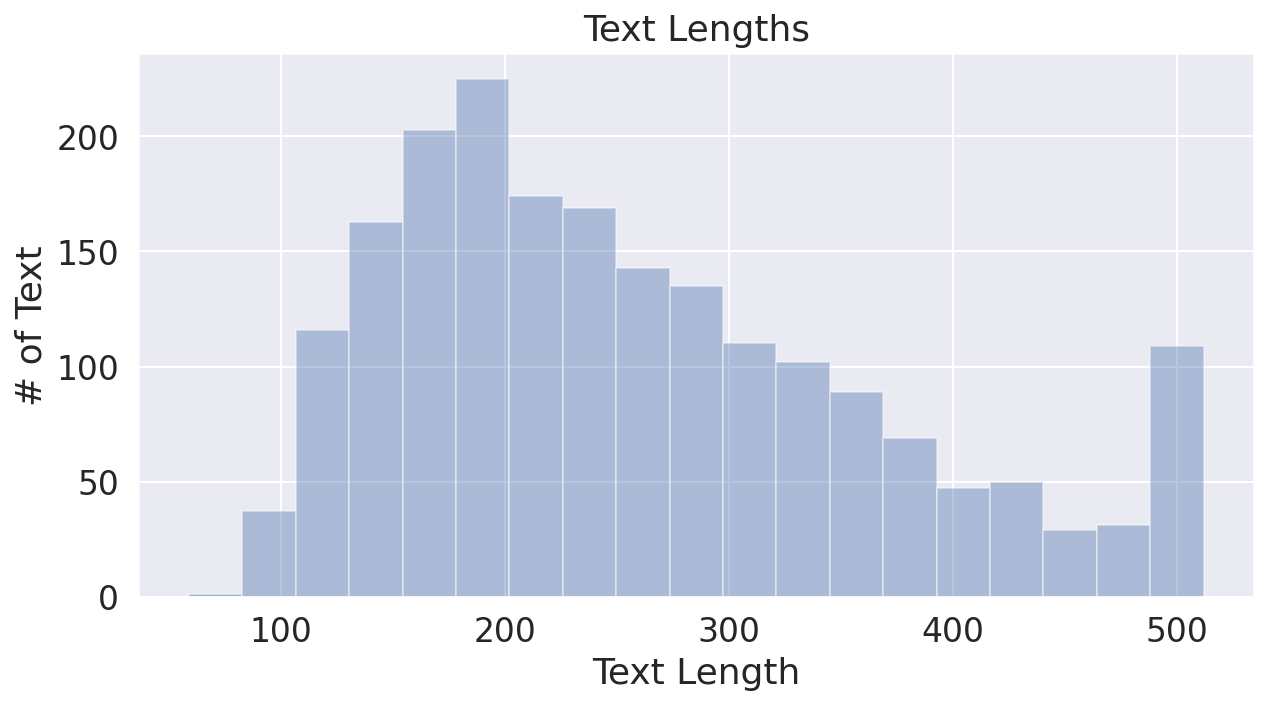

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('# of Text')


Clearly most comments are "short", and there's a long tail of longer comments. 

Just how many of the examples run into the 512-token limit?

In [33]:
# Count the number of sentences that had to be truncated to 512 tokens.
num_truncated = lengths.count(512)

# Compare this to the total number of training sentences.
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

91 of 2,002 sentences (4.5%) in the training set are longer than 512 tokens.


# Part II - BERT Fine-Tuning

## 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

### 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [34]:
import torch.nn as nn
from transformers import AutoConfig, AutoModel, AdamW, get_linear_schedule_with_warmup

In [49]:
import torch.nn.functional as F

In [35]:
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(
        self,
        pretrained_model_name: str,
        num_classes: int = None,
        dropout: float = 0.3
    ):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(
            pretrained_model_name, num_labels=num_classes
        )

        self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None, head_mask=None):
        """Compute class probabilities for the input sequence.

        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"

        # taking BERTModel output
        # see https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel
        bert_output = self.model(
            input_ids=input_ids, attention_mask=attention_mask, head_mask=head_mask
        )
        # we only need the hidden state here and don't need
        # transformer output, so index 0
        seq_output = bert_output[0]  # (bs, seq_len, dim)
        # mean pooling, i.e. getting average representation of all tokens
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        scores = self.classifier(pooled_output)  # (bs, num_classes)

        return scores

In [36]:
N_EPOCH = 10

In [37]:
model = BertForSequenceClassification(
    pretrained_model_name=MODEL_NAME,
    num_classes=data_df.label.unique().shape[0],
    dropout=0.3
).to(device)

In [38]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [39]:
steps_per_epoch=len(df_train) // BATCH_SIZE
warmup_step = steps_per_epoch // 3
total_steps = steps_per_epoch * N_EPOCH - warmup_step

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            warmup_step,
                                            total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [40]:
prediction = model(input_ids=mini_batch_data['input_ids'].to(device),
                   attention_mask=mini_batch_data['attention_mask'].to(device)
)

In [41]:
print(prediction.size())
prediction[:3]

torch.Size([16, 5])


tensor([[-0.0231,  0.0459, -0.0011, -0.1490, -0.0440],
        [ 0.1313,  0.1061,  0.0692, -0.0747, -0.1700],
        [ 0.0722, -0.0199,  0.0503, -0.0660, -0.0977]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [42]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0

    for d in data_loader:
        optimizer.zero_grad()
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
from collections import defaultdict

In [45]:
%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(N_EPOCH):
    print(f'Epoch {epoch + 1}/{N_EPOCH}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs
Epoch 1/10
----------
Train loss 0.6756635136266668 accuracy 0.7532467532467533
Val   loss 0.12110348391745772 accuracy 0.9729729729729729

Epoch 2/10
----------
Train loss 0.07422573703695975 accuracy 0.9805194805194806
Val   loss 0.08998958876223437 accuracy 0.9729729729729729

Epoch 3/10
----------
Train loss 0.0438096874027646 accuracy 0.9885114885114885
Val   loss 0.09267112842228796 accuracy 0.9819819819819819

Epoch 4/10
----------
Train loss 0.019295366729484013 accuracy 0.9945054945054945
Val   loss 0.10551371927639204 accuracy 0.9819819819819819

Epoch 5/10
----------
Train loss 0.006112729158577701 accuracy 0.997002997002997
Val   loss 0.12341159062426803 accuracy 0.9819819819819819

Epoch 6/10
----------
Train loss 0.001024857046551973 accuracy 1.0
Val   loss 0.1384385254392068 accuracy 0.9819819819819819

Epoch 7/10
----------
Train loss 0.0005709109030985495 accuracy 1.0
Val   loss 0.10495913310192659 acc

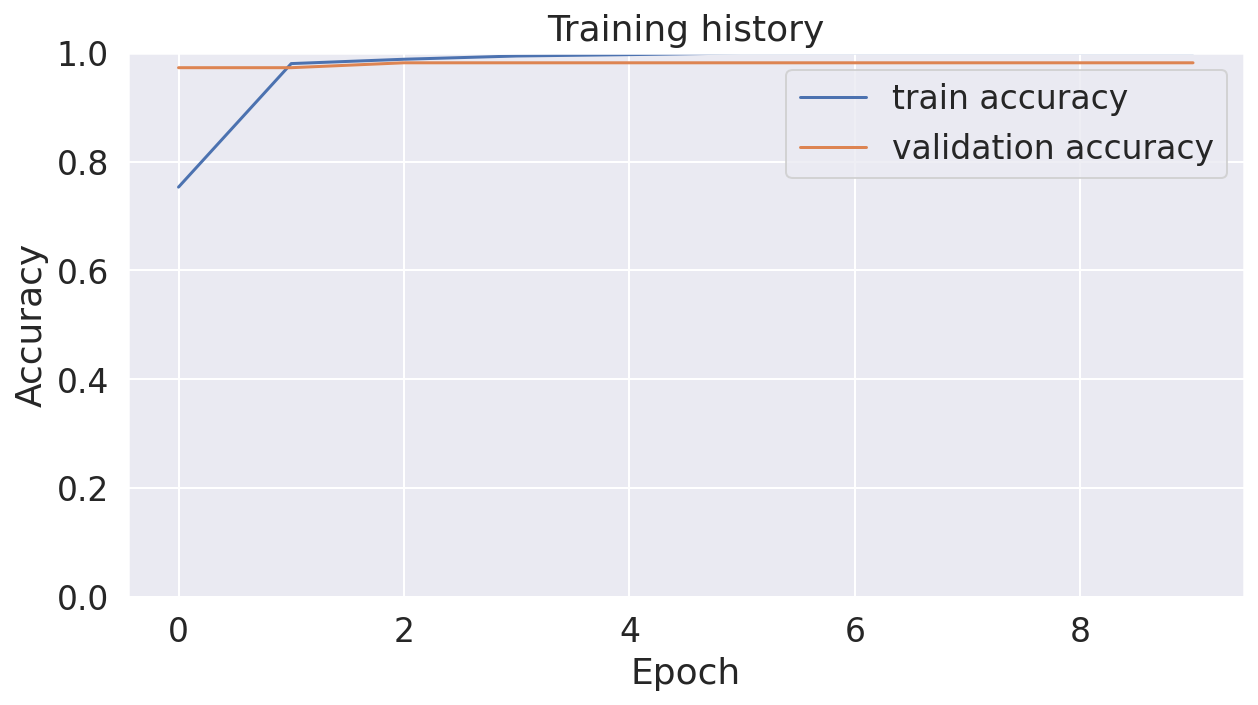

In [46]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [52]:
def get_predictions(model, data_loader,):
    model = model.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

In [55]:
from sklearn.metrics import confusion_matrix, classification_report

In [53]:
y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader,
)

In [57]:
print(classification_report(y_test, y_pred, target_names=set_of_labels))

               precision    recall  f1-score   support

entertainment       1.00      0.85      0.92        27
     business       1.00      1.00      1.00        27
        sport       0.85      1.00      0.92        17
         tech       1.00      1.00      1.00        26
     politics       0.94      1.00      0.97        15

     accuracy                           0.96       112
    macro avg       0.96      0.97      0.96       112
 weighted avg       0.97      0.96      0.96       112



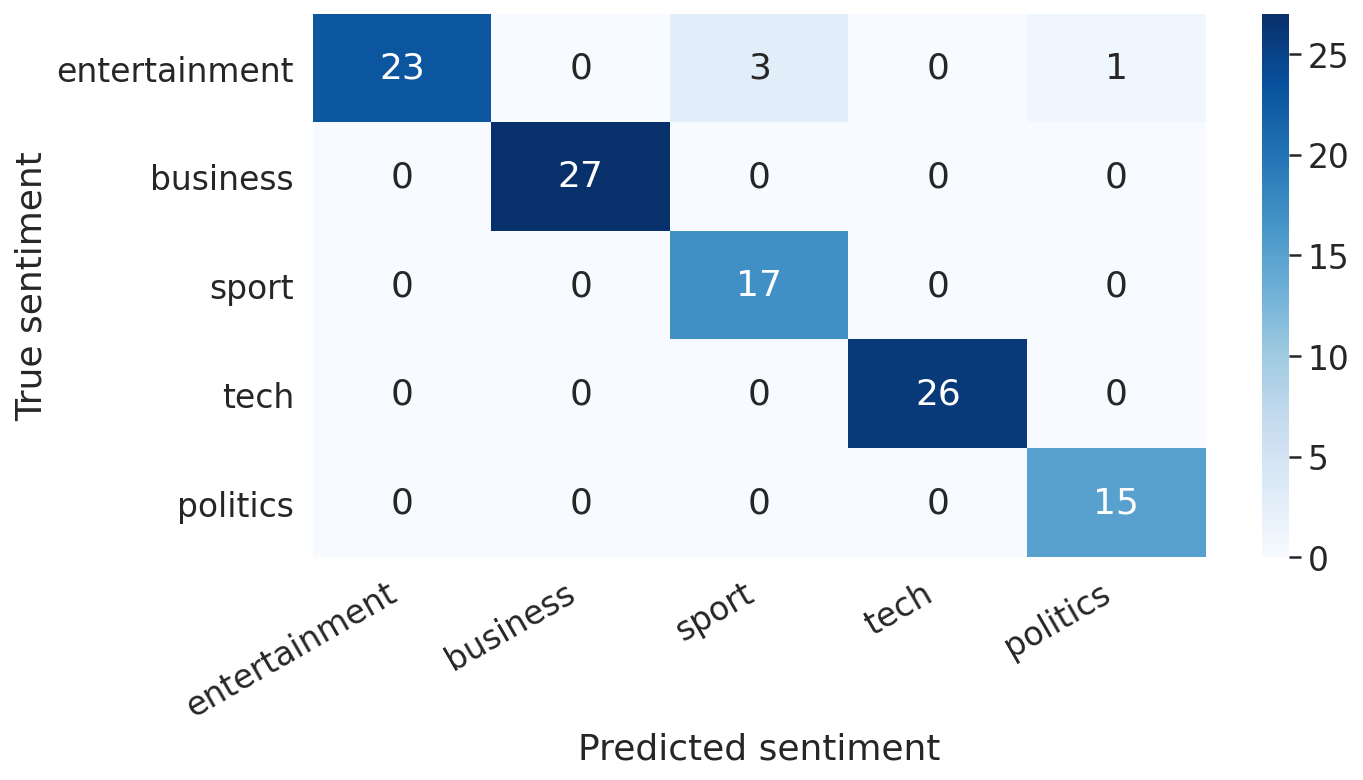

In [59]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=set_of_labels, columns=set_of_labels)
show_confusion_matrix(df_cm)

### 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 4.3. Training Loop

In each pass, we will train the model on our full training set, and then measure it's accuracy on our 10% holdout validation set.

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,956.    Elapsed: 0:01:12.
  Batch   200  of  1,956.    Elapsed: 0:02:26.
  Batch   300  of  1,956.    Elapsed: 0:03:44.
  Batch   400  of  1,956.    Elapsed: 0:05:02.
  Batch   500  of  1,956.    Elapsed: 0:06:20.
  Batch   600  of  1,956.    Elapsed: 0:07:38.
  Batch   700  of  1,956.    Elapsed: 0:08:56.
  Batch   800  of  1,956.    Elapsed: 0:10:15.
  Batch   900  of  1,956.    Elapsed: 0:11:33.
  Batch 1,000  of  1,956.    Elapsed: 0:12:51.
  Batch 1,100  of  1,956.    Elapsed: 0:14:09.
  Batch 1,200  of  1,956.    Elapsed: 0:15:28.
  Batch 1,300  of  1,956.    Elapsed: 0:16:46.
  Batch 1,400  of  1,956.    Elapsed: 0:18:05.
  Batch 1,500  of  1,956.    Elapsed: 0:19:23.
  Batch 1,600  of  1,956.    Elapsed: 0:20:41.
  Batch 1,700  of  1,956.    Elapsed: 0:21:59.
  Batch 1,800  of  1,956.    Elapsed: 0:23:17.
  Batch 1,900  of  1,956.    Elapsed: 0:24:35.

  Average training loss: 0.14
  Training epcoh took: 0:25:18

R

Let's take a look at our training loss over all batches:

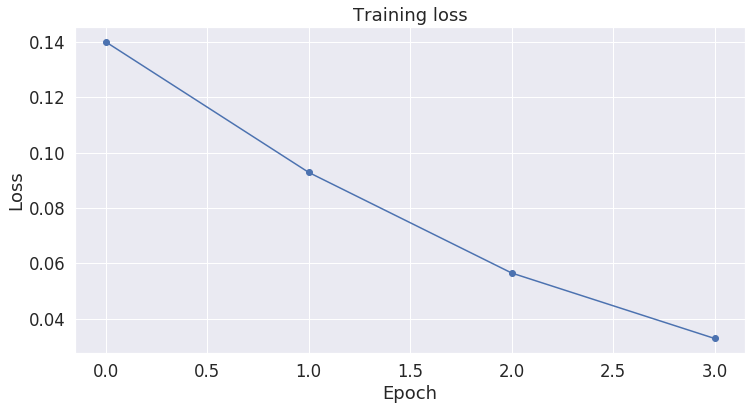

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sen in test_comments.comment:
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Truncate all sentences.                        
                   )
    
    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} test comments'.format(len(test_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = test_comments.attack.to_numpy().astype(int)

print('{:>10,} positive (contains attack)'.format(np.sum(test_labels)))
print('{:>10,} negative (not an attack)'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                               dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

DONE.

    23,178 test comments
     2,756 positive (contains attack)
    20,422 negative (not an attack)


### 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 23,178 test sentences...
  Batch   100  of    725.    Elapsed: 0:00:25.
  Batch   200  of    725.    Elapsed: 0:00:52.
  Batch   300  of    725.    Elapsed: 0:01:20.
  Batch   400  of    725.    Elapsed: 0:01:47.
  Batch   500  of    725.    Elapsed: 0:02:14.
  Batch   600  of    725.    Elapsed: 0:02:41.
  Batch   700  of    725.    Elapsed: 0:03:08.
    DONE.


In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

Let's peek at the model's outputs for the first 10 test samples, along with the correct labels for each.

In [ ]:
predictions[0:10]

array([[ 4.039028 , -4.3186197],
       [ 4.8740277, -4.8348045],
       [ 4.831533 , -4.8746214],
       [ 4.7093406, -4.7833867],
       [ 4.782529 , -4.811639 ],
       [ 4.8868985, -4.826337 ],
       [ 4.999706 , -4.867378 ],
       [ 4.606828 , -4.708927 ],
       [ 4.68402  , -4.754583 ],
       [ 4.785246 , -4.5924516]], dtype=float32)

In [ ]:
true_labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

These first ten examples all look correct (high confidence for label 0 and low confidence for label 1)! Let's see how we did on the full test set.

The accuracy metric chosen by the authors for this dataset is the "ROC AUC" (Receiver Operating Characteristic, Area Under the Curve) rather than straight accuracy (number right / total examples).

*ROC AUC*

To illustrate the purpose of this metric, let's say that you were going to deploy this comment classifier on your website to automatically flag bad comments. In order to do that, you would have to make a decision about how confident you needed the classifier to be before flagging a comment as a personal attack.
* If it was critical that no bad comments be missed, then you might choose to set a fairly low threshold, and then have a human review what the classifier flags. This would help ensure that bad comments would be caught, but at the cost of getting more false positives that the moderator would have to deal with.
* If it wasn't critical to catch them all, and you wanted as few as possible to manually review, then you might you set a higher threshold so that you don't have as many flagged comments to review (at the risk of missing some attacks). 

The ROC AUC takes into account the fact that you can adjust the threshold to trade off false positives and false negatives, and yields a score which tries to capture overall accuracy independent of where you choose to put that threshold.

In [ ]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# Use the model output for label 1 as our predictions.
p1 = predictions[:,1]

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.969


This is a great score!

The baseline performance from the [original notebook](https://github.com/ewulczyn/wiki-detox/blob/master/src/figshare/Wikipedia%20Talk%20Data%20-%20Getting%20Started.ipynb) using tf-idf + Logistic Regression is 0.957.

In a previous experiment (in my [word2vec course](https://www.chrismccormick.ai/word2vec-the-course)), I trained a word2vec model on this dataset and then used it as the embeddings for an LSTM classifier. That approach achieved a score of 0.966. 

We've beaten both with minimal effort using BERT!

## 6. Save Trained Model


### 6.1. Saving to Disk

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

### 6.2. Backing Up to Google Drive

To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
gdrive_path = "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

# Create output directory if needed
if not os.path.exists(gdrive_path):
    os.makedirs(gdrive_path)

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

# Part III - Semantic Similarity

In Part III, we'll walk through an example of using BERT to measure the "semantic similarity" of two pieces of text. "Semantic similarity" refers to how close in meaning the pieces of text are.

As a demonstration of this capability, we'll implement code to compare an arbitrary piece of input text (it could be from the dataset or one we supply ourselves) with all of the comments in the dataset and return the comments that are most similar in meaning to the input text.

## 7. Vectorize Comments 

In this section, we will use our fine-tuned BERT model to extract sentence embeddings for all of the training comments.

To create these embeddings, we'll simply run the comments through the model the same way we did for training, but we'll take the embedding corresponding to the `[CLS]` token from the final BERT Transformer layer. It's the blue rectangle at the top left of the following illustration:

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)





### 7.1. Modifying Our Model to Output Embeddings

Important: Before we can use our fine-tuned model for extracting embeddings, we first need to reload the model from disk with the `output_hidden_states` flag set to `True`.

(TODO - You can try setting `model.output_hidden_states = True`, but I'm not sure if this will work, haven't tried it...)



**Load from Google Drive**

If you need to restore your model from Google Drive, the following two cells demonstrate how to do this.

In [ ]:
model.output_hidden_states = True

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Copy the model files back from Google Drive to the Colab instance. 
!cp -r "./drive/My Drive/BERT Document Classification Tutorial/model_save/" ./model_save/

Now we can load our model's weights, this time enabling the `output_hidden_states` flag. 

This cell also demonstrates how to load the tokenizer from disk,though we haven't made any changes to it.

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# The name of the folder containing the model files.
output_dir = './model_save/'

# Load our fine-tuned model, and configure it to return the "hidden states", 
# from which we will be taking our text embeddings.
model = BertForSequenceClassification.from_pretrained(
    output_dir,
    output_hidden_states = True, # Whether the model returns all hidden-states.
) 

# Load the tokenizer.
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 7.2. text_to_embedding function

Here we'll define a function which can take an arbitrary piece of text and use our fine-tuned BERT model to compute a feature vector (aka "embedding") for the text.

Again, we'll be using the 768-feature vector corresponding to the special `[CLS]` token, taken from the final transformer layer.

Note that, for converting large amounts of text, we could improve our performance by modifying this function to accept multiple input texts at once. GPUs (and CPUs) are most efficient when they are given a *batch* of inputs to work on.

In [ ]:
import torch
from keras.preprocessing.sequence import pad_sequences

def text_to_embedding(tokenizer, model, in_text):
    '''
    Uses the provided BERT `model` and `tokenizer` to generate a vector 
    representation of the input string, `in_text`.

    Returns the vector stored as a numpy ndarray.
    '''

    # ===========================
    #    STEP 1: Tokenization
    # ===========================

    MAX_LEN = 128

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Truncate the sentence to MAX_LEN if necessary.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end. (After truncating!)
    #   (4) Map tokens to their IDs.
    input_ids = tokenizer.encode(
                        in_text,                    # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.                        
                   )    

    # Pad our input tokens. Truncation was handled above by the `encode`
    # function, which also makes sure that the `[SEP]` token is placed at the
    # end *after* truncating.
    # Note: `pad_sequences` expects a list of lists, but we only have one
    # piece of text, so we surround `input_ids` with an extra set of brackets.
    results = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", 
                              truncating="post", padding="post")
    
    # Remove the outer list.
    input_ids = results[0]

    # Create attention masks    
    attn_mask = [int(i>0) for i in input_ids]
    
    # Cast to tensors.
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the "batch" (even though there is only one 
    # input in this batch.)
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    # ===========================
    #    STEP 2: BERT Model
    # ===========================

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Copy the inputs to the GPU
    # Note -- I got stuck here for a while because I didn't assign the result 
    # back to the variable! Geez!
    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)
    
    # Telling the model not to build the backwards graph will make this 
    # a little quicker.
    with torch.no_grad():        

        # Forward pass, return hidden states and predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        logits, encoded_layers = model(
                                    input_ids = input_ids, 
                                    token_type_ids = None, 
                                    attention_mask = attn_mask)
        
    # Retrieve our sentence embedding--take the `[CLS]` embedding from the final
    # layer.
    layer_i = 12 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]
        
    # Grab the embedding.
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to the CPU and convert to numpy ndarray.
    vec = vec.detach().cpu().numpy()

    return(vec)


### 7.3. Vectorize Dataset

We'll go back to the original dataset here. It should still be in memory as a pandas dataframe named `comments`.

Let's start by vectorizing a single comment.

In [ ]:
# Get the text from one of the comments.
input_text = comments.iloc[10].comment

# Use `textwrap` to print the sentence nicely.
wrapper = textwrap.TextWrapper(initial_indent="    ", subsequent_indent="    ", 
                               width = 80)

print('Getting embedding for sentence:\n\n', wrapper.fill(input_text))

# Use the BERT model and tokenizer to generate an embedding for `input_text`.
vec = text_to_embedding(tokenizer, model, input_text)

print('\nDone. Embedding shape:', str(vec.shape))

Getting embedding for sentence:

       :Correct. Full biographical details will put down his birth details, etc.
    It is just a marker to me at the moment to detail the WR aspect. He
    certainly wasn't Belarus; as a geo-political entity it had no real existence
    at the time. I have put a tbc marker on this article for now.

Done. Embedding shape: (768,)


It's working! In order to perform similarity search against this comments dataset, we now need to vectorize *all* of the comments.

Define a small helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Loop over all of the comments in the dataset, converting each one. Prints progress periodically. This took just under 1 hour for me to run in Colab with a T4 GPU.

In [ ]:
import time

# Track the time.
t0 = time.time()

# Store the set of embeddings.
embeddings = []

num_comments = len(comments)

print('Generating sentence embeddings for all {:,} comments...'.format(num_comments))

row_num = 0

# For each row of the dataframe...
for index, row in comments.iterrows():

    # Progress update every 2,000 comments.
    if row_num % 2000 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_comments - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Comment {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(row_num, num_comments, elapsed, remaining))

    # Vectorize this comment.
    vec = text_to_embedding(tokenizer, model, row.comment)

    # Store the embeddings.
    embeddings.append(vec) 

    row_num += 1


Generating sentence embeddings for all 115,864 comments...
  Comment   2,000  of  115,864.    Elapsed: 0:00:58. Remaining: 0:55:07
  Comment   4,000  of  115,864.    Elapsed: 0:01:57. Remaining: 0:54:38
  Comment   6,000  of  115,864.    Elapsed: 0:02:56. Remaining: 0:53:45
  Comment   8,000  of  115,864.    Elapsed: 0:03:54. Remaining: 0:52:41
  Comment  10,000  of  115,864.    Elapsed: 0:04:52. Remaining: 0:51:33
  Comment  12,000  of  115,864.    Elapsed: 0:05:50. Remaining: 0:50:32
  Comment  14,000  of  115,864.    Elapsed: 0:06:49. Remaining: 0:49:36
  Comment  16,000  of  115,864.    Elapsed: 0:07:47. Remaining: 0:48:36
  Comment  18,000  of  115,864.    Elapsed: 0:08:46. Remaining: 0:47:41
  Comment  20,000  of  115,864.    Elapsed: 0:09:45. Remaining: 0:46:42
  Comment  22,000  of  115,864.    Elapsed: 0:10:43. Remaining: 0:45:43
  Comment  24,000  of  115,864.    Elapsed: 0:11:41. Remaining: 0:44:45
  Comment  26,000  of  115,864.    Elapsed: 0:12:40. Remaining: 0:43:46
  Com

In [ ]:
import numpy as np

# Convert the list of vectors into a 2D array.
vecs = np.stack(embeddings)

vecs.shape

(115864, 768)

Since creating those embeddings was such a lengthy process, let's be sure to save the embeddings to disk in case we want to reload them another time.

In [ ]:
import os

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Use numpy to write out the matrix of embeddings.
print("Saving embeddings to: ./model_save/embeddings.npy")
np.save('./model_save/embeddings.npy', vecs)

# Copy the embeddings to a directory in your Google Drive.
!cp -r ./model_save/embeddings.npy "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

Saving embeddings to ./model_save/


## 8. Semantic Similarity Search

Now that we have our comments all vectorized, we are ready to make them "searchable".

We do this using a technique called "k-Nearest Neighbor Search" or "k-NN". Simply put, we use a distance metric such as Euclidean distance, calculate that distance between our "query" vector and all of the vectors to be searched, then sort the distances to find the closest matches.

All of those distance calculations can make k-NN search computationally expensive and slow. There are a number of libraries out there for accelerating k-NN using carefully optimized code and / or approximation techniques.

I personally like the FAISS (Facebook AI Similarity Search) library, in part because it has a really excellent GPU implementation.

Using the GPU, we can perform "brute-force" k-NN search (meaning no approximation techniques which compromise on accuracy) on this dataset quickly.

### 8.1. k-NN with FAISS and GPU

First we'll need to install FAISS.

In [ ]:
!pip install faiss

     |████████████████████████████████| 4.7MB 6.4MB/s 


In [ ]:
!pip install faiss-gpu

     |████████████████████████████████| 41.0MB 73kB/s 


To create a GPU index with FAISS, you first create it on the CPU, then copy it over.

A "Flat" index means that it's brute-force, with no approximation tricks.

In [ ]:
import faiss

# =====================================
#            FAISS Setup
# =====================================

# Build a flat (CPU) index
cpu_index = faiss.IndexFlatL2(vecs.shape[1])

# Use 1 GPU.
n_gpu = 1

# Print the number of available GPUs. 
print('Number of available GPUs: %d    Using: %d' % (faiss.get_num_gpus(), n_gpu))

# If using multiple GPUs, enable sharding so that the dataset is divided across 
# the GPUs rather than replicated.
co = faiss.GpuMultipleClonerOptions()
co.shard = True

# Make it into a gpu index
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index, co=co, ngpu=n_gpu)

# Add vecs to our GPU index
print('Adding dataset to index...')
t0 = time.time()    

gpu_index.add(vecs)

elapsed = time.time() - t0
print('Building index took %.2f seconds' % (elapsed))


Number of available GPUs: 1    Using: 1
Adding dataset to index...
Building index took 0.05 seconds


Now let's try taking one of the comments from the dataset, and searching for the most semantically similar comments.

In [ ]:
# Comment number 4 is short and sweet.
print('==== Input Comment =====')
print('Comment #4:')
print(wrapper.fill(comments.iloc[4].comment))

# Let's find the 5 most similar comments.
D, I = gpu_index.search(vecs[4].reshape(1, 768), k=5) 

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')



==== Input Comment =====
Comment #4:
    This page will need disambiguation.

==== Top 5 Results ====
Comment #4:
L2 Distance: 0.00
    "This page will need disambiguation. "

Comment #39,578:
L2 Distance: 13.38
    "  This page needs to be expand.   "

Comment #48,854:
L2 Distance: 14.63
    "This page's history is completely not neutral It needs to be revamped."

Comment #100,779:
L2 Distance: 16.01
    " Description on image page is confusing about this.   "

Comment #31,644:
L2 Distance: 16.07
    "   :::: This image is not Orphaned, it WILL be placed back in the article
    soon.    "



Using our `text_to_embedding` function, we can also define new text to use as our query. Let's try writing a new sentence that's similar in meaning to comment #4, but uses different language. The word "disambiguate" means "remove uncertainty of meaning from", so I've written "The meaning of this page needs to be clarified."



In [ ]:
query_text = "The meaning of this page needs to be clarified."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = gpu_index.search(query_vec.reshape(1, 768), k=5) 

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')




==== Top 5 Results ====
Comment #4:
L2 Distance: 12.24
    "This page will need disambiguation. "

Comment #48,854:
L2 Distance: 14.91
    "This page's history is completely not neutral It needs to be revamped."

Comment #39,578:
L2 Distance: 15.11
    "  This page needs to be expand.   "

Comment #8,612:
L2 Distance: 15.97
    "why can't i edit this page?"

Comment #100,224:
L2 Distance: 16.45
    "please add more information on this topic."



The results look pretty good! 

Let's try another query, this time with a different intent.

In [ ]:
query_text = "This article really needs more citations."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = gpu_index.search(query_vec.reshape(1, 768), k=5) 

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')




==== Top 5 Results ====
Comment #88,451:
L2 Distance: 16.71
    "  I intend to expand the article so it will be more complete. [  ]"

Comment #18,864:
L2 Distance: 17.63
    "  I, of all people, ahouldn't be saying this, but the article needs
    citations. "

Comment #18,370:
L2 Distance: 17.95
    "This Article created September 16, 2006.  Please EXPAND if possible!   "

Comment #15,196:
L2 Distance: 18.28
    "  This article are necessary? "

Comment #102,270:
L2 Distance: 18.57
    " ::::No.  The comments are completely relevant to this article."



Try another query for yourself!
